<a href="https://colab.research.google.com/github/keyboard-jo/dsw_hackathon_bdj/blob/main/churn_customer_segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install prince
!pip install adjustText
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 6.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:

import prince
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from adjustText import adjust_text
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
import seaborn as sns



In [38]:
df = pd.read_excel("/content/drive/MyDrive/datasets/Telco_customer_churn_adapted_v2.xlsx")

In [39]:
df.rename(columns={'Monthly Purchase (Thou. IDR)': 'Monthly_Purchase'}, inplace=True)

df.rename(columns={'CLTV (Predicted Thou. IDR)': 'CLTV'}, inplace=True)

df['Total_Purchase'] = df['Monthly_Purchase'] * df['Tenure Months']

df = df.drop(['Customer ID','Location','Longitude','Latitude'], axis = 1)

CATEGORICAL COLUMN HEATMAP

In [8]:
#TURNING CHURN NUMBERIC
tempdf = df.copy()
tempdf['Churn Label'] = tempdf['Churn Label'].replace(to_replace='Yes', value=1)
tempdf['Churn Label'] = tempdf['Churn Label'].replace(to_replace='No',  value=0)

data_dummy = pd.get_dummies(tempdf[['Churn Label','Games Product','Music Product','Call Center','Video Product','Use MyApp']], dtype=float)
categorical = 'Churn Label','Games Product','Music Product','Call Center','Video Product','Use MyApp'

fig = px.bar(data_dummy.corr()['Churn Label'].sort_values(ascending = False),
             color = 'value')
fig.show()

# NO CONNECTION TO GAMES PRODUCT, MUSIC PRODUCT AND CALL CENTER HAS POSITIVE CORRELATION TO CHURN
# NO INTERNET SERVICE FOR MYAPP, VIDEO, MUSIC, GAMES HAS NEGATIVE CORRELATION TO CHURN

CHURN PREDICTION (LOGISTIC REGRESSION)

In [9]:
def encode_data(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

datav1 = df.apply(lambda x: encode_data(x))
datav1.head()

figure = px.bar(datav1.corr()['Churn Label'].sort_values(ascending = False),
             color = 'value')
figure.show()

BALANCING DATASET FOR TRAINING

In [10]:
x = datav1.drop("Churn Label", axis = 1)
y = datav1['Churn Label']

x = pd.DataFrame(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2,random_state=42)

numerical_columns = [ 'CLTV', 'Total_Purchase', 'Monthly_Purchase']
categorical_columns = x.drop(columns=numerical_columns).columns
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Fit and transform the data using the column transformer
X_train = preprocessor.fit_transform(x_train)
X_test = preprocessor.transform(x_test)

smote = SMOTE(sampling_strategy=1, random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

<Axes: >

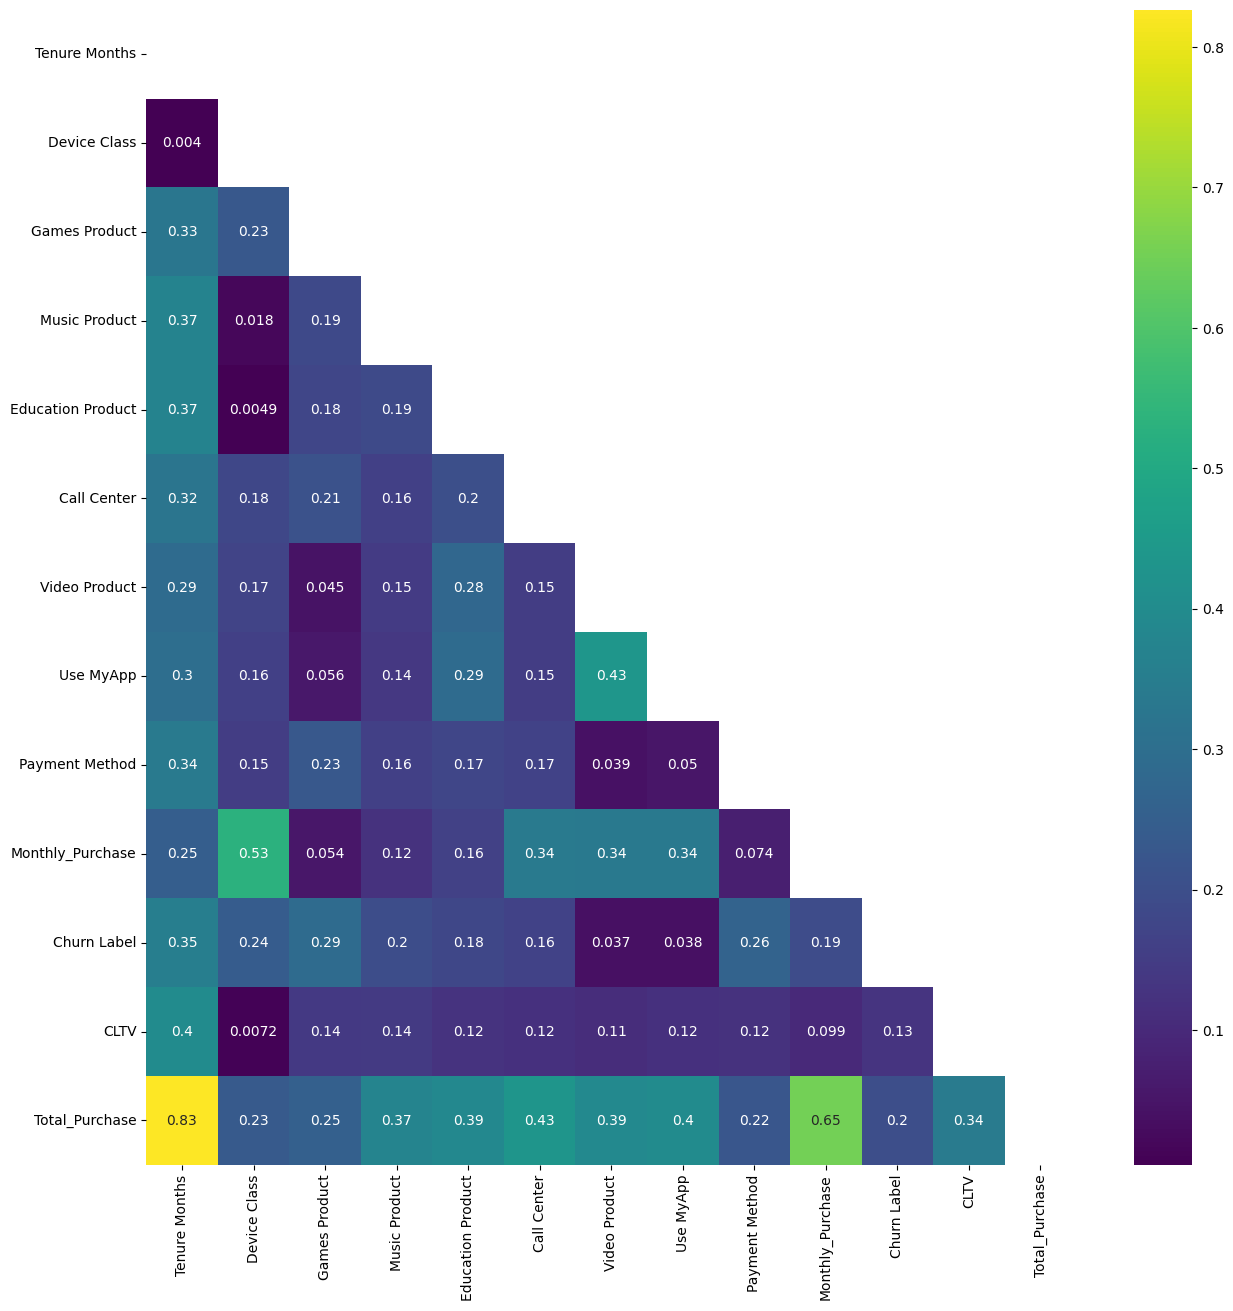

In [11]:
plt.figure(figsize=(15, 15))
corr = datav1.corr()
mask = np.tri(*corr.shape).T
sns.heatmap(corr.abs(), mask=mask, annot=True, cmap='viridis')

MODEL BUILDING

In [12]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(x_resampled, y_resampled)

best_lr_model = grid_search.best_estimator_


y_pred_lr = best_lr_model.predict(x_test)


print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

Logistic Regression:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80      1009
           1       0.53      0.72      0.61       400

    accuracy                           0.74      1409
   macro avg       0.70      0.73      0.71      1409
weighted avg       0.77      0.74      0.75      1409



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  Fil

WEIGHT, ODDS RATIO AND PERCENTAGE EFFECT

In [13]:
coefficients = best_lr_model.coef_[0]
odds_ratios = [2**coef for coef in coefficients]

results_list = []
# Print coefficients, odds ratios, and percentage effect
for feature, coef, odds_ratio in zip(x.columns, coefficients, odds_ratios):
    odds_ratio = 2**coef
    percentage_effect = (odds_ratio - 1) * 100

    # Append the results to the list
    results_list.append([feature, coef, odds_ratio, percentage_effect])

results_df = pd.DataFrame(results_list, columns=["Feature", "Weight (Coefficient)", "Odds Ratio", "Percentage Effect"])

# Print the table
display(results_df)

,Feature,Weight (Coefficient),Odds Ratio,Percentage Effect
0,Tenure Months,-0.075492,0.949019,-5.098143
1,Device Class,-0.124087,0.917584,-8.241560
2,Games Product,-0.613396,0.653656,-34.634356
3,Music Product,-0.339012,0.790582,-20.941771
4,Education Product,-0.269525,0.829593,-17.040708
5,Call Center,-1.408249,0.376769,-62.323135
6,Video Product,-0.141862,0.906349,-9.365109
7,Use MyApp,-0.165276,0.891758,-10.824238
8,Payment Method,0.015810,1.011019,1.101862
9,Monthly_Purchase,0.019668,1.013726,1.372624


# FAMD PREPARATION

In [40]:
# Standardized columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# numerical_columns = numerical_columns.drop("Churn Label")

numerical_df = df[numerical_columns]

scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(numerical_df), columns=numerical_df.columns)

df_pre = pd.concat([df.drop(columns=numerical_columns), df_standardized], axis=1)

In [41]:
df_pre

,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Churn Label,Tenure Months,Monthly_Purchase,CLTV,Total_Purchase
0,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,Yes,-1.236724,-0.362660,-0.981675,-0.959071
1,High End,No,No,No,No,No,No,Pulsa,Yes,-1.236724,0.197365,-1.436462,-0.944189
2,High End,No,No,Yes,No,Yes,Yes,Pulsa,Yes,-0.992402,1.159546,0.821409,-0.654598
3,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,Yes,-0.177995,1.330711,0.509483,0.289158
4,High End,No,Yes,Yes,No,Yes,Yes,Debit,Yes,0.677133,1.294151,0.794358,1.237197
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Low End,No internet service,No internet service,No internet service,No,No internet service,No internet service,Debit,No,1.613701,-1.449476,0.765617,-0.334183
7039,Mid End,Yes,No,Yes,Yes,Yes,Yes,Digital Wallet,No,-0.340876,0.665992,-1.910691,-0.107915
7040,High End,No,Yes,Yes,No,Yes,Yes,Credit,No,1.613701,1.277533,0.980330,2.274525
7041,Mid End,Yes,No,No,No,No,No,Pulsa,No,-0.870241,-1.168632,-1.358692,-0.862849


In [42]:
famd = prince.FAMD(
    n_components=10
)
famd = famd.fit(df_pre)

In [43]:
famd.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,29.312,36.41%,36.41%
1,11.087,13.77%,50.18%
2,7.983,9.92%,60.10%
3,4.510,5.60%,65.70%
4,4.255,5.29%,70.99%
5,3.800,4.72%,75.71%
6,3.314,4.12%,79.83%
7,3.193,3.97%,83.79%
8,3.095,3.85%,87.64%


In [44]:
df_final = famd.transform(df_pre)
df_final = df_final.iloc[:, 0:6]

df_final

component,0,1,2,3,4,5
0,-1.916987,-2.852622,4.727947,-0.012964,0.865107,4.309713
1,-2.979052,-6.854261,-1.306869,-0.022758,-0.974213,-0.065112
2,-3.364325,-1.540315,-6.019463,-0.724512,2.404399,-1.322979
3,-4.165767,0.397690,-5.253764,-0.796206,3.300293,-1.432435
4,-3.227889,2.222703,-5.107451,3.315472,-0.784948,0.427495
...,...,...,...,...,...,...
7038,9.958709,1.447965,-0.583411,3.536213,-1.720734,-1.646068
7039,-2.531226,3.991339,2.191134,-1.065563,6.620658,-0.983490
7040,-2.837647,4.296587,-3.705226,-2.807974,-2.517028,0.417261
7041,-2.252916,-3.277382,4.336232,-0.119728,0.094598,-0.490658


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

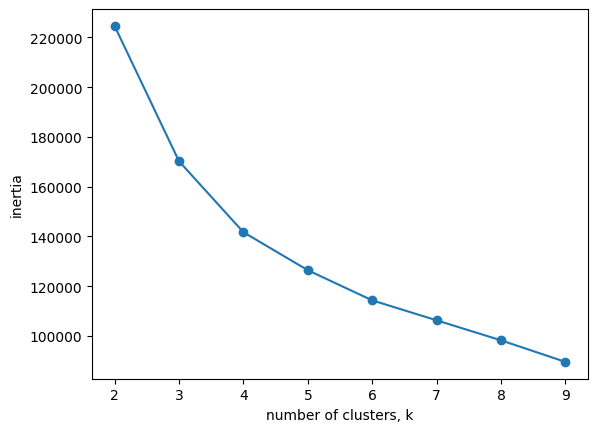

In [45]:
ks = range(2,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_final)
    inertias.append(model.inertia_)

plt.plot(ks,inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

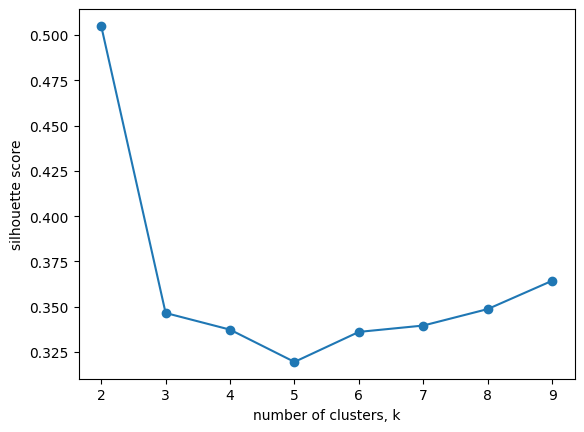

In [46]:
ks = range(2,10)
ss = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(df_final)
    labels = model.labels_
    ss.append(silhouette_score(df_final, labels))

plt.plot(ks,ss, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('silhouette score')
plt.xticks(ks)
plt.show()

# FAMD EDA

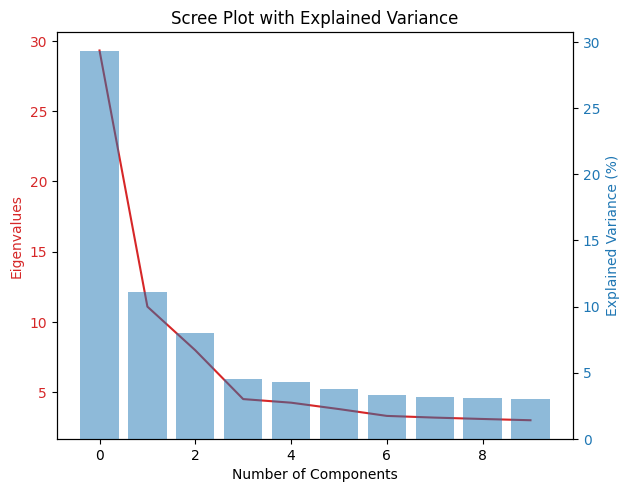

In [47]:
# Scree plot
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Eigenvalues', color=color)
ax1.plot(famd.eigenvalues_, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Bar plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Explained Variance (%)', color=color)
ax2.bar(range(0, len(famd.eigenvalues_)), famd.eigenvalues_, alpha=0.5, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Scree Plot with Explained Variance")
plt.show()


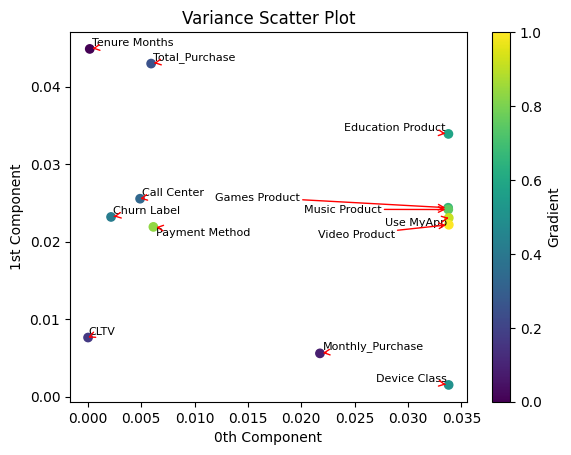

In [48]:
scatter_df = (famd.column_contributions_).iloc[:, 0:2]

gradient_values = np.linspace(0, 1, len(scatter_df))

new_columns = ["0th component", "1st component"]

scatter_df.columns = new_columns

fig, ax = plt.subplots()

scatter = ax.scatter(scatter_df['0th component'], scatter_df['1st component'], label='Points', c=gradient_values, cmap='viridis')

cbar = plt.colorbar(scatter)
cbar.set_label('Gradient')

small_x = 0.001

texts = []

for i in range(len(scatter_df)):
    texts.append(ax.text(scatter_df['0th component'][i], scatter_df['1st component'][i], scatter_df.index[i], fontsize=8))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

ax.set_xlabel('0th Component')
ax.set_ylabel('1st Component')
ax.set_title('Variance Scatter Plot')

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



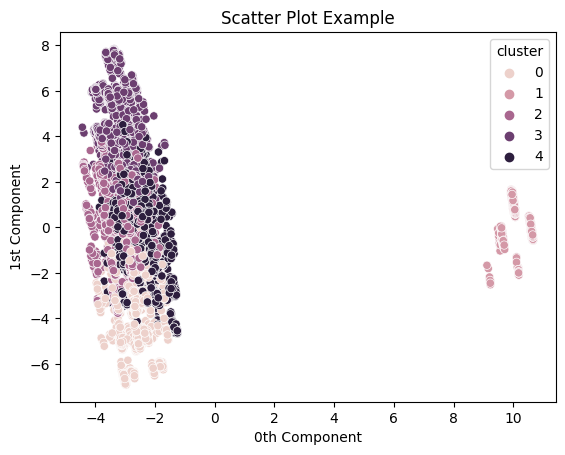

In [49]:
df_clustering = pd.DataFrame()

df_clustering[["0th component", "1st component"]] = df_final.iloc[:, 0:2]

model = KMeans(n_clusters=5, random_state=42)
model.fit(df_final)

df_clustering["cluster"] = model.labels_

sns.scatterplot(x='0th component', y="1st component", data=df_clustering, color='blue', marker='o', hue="cluster")
plt.title('Scatter Plot Example')
plt.xlabel('0th Component')
plt.ylabel('1st Component')

plt.show()

In [50]:
import plotly.graph_objects as go

df_clustering = pd.DataFrame()

df_clustering[["0th component", "1st component", "2nd component"]] = df_final.iloc[:, 0:3]

model = KMeans(n_clusters=5, random_state=42)
model.fit(df_final)

df_clustering["cluster"] = model.labels_

# ---
fig = go.Figure(data=[go.Scatter3d(x=df_clustering["0th component"], y=df_clustering["1st component"], z=df_clustering["2nd component"], mode='markers', marker=dict(size=10, color=df_clustering["cluster"]))])

fig.update_layout(scene=dict(xaxis_title='0th component', yaxis_title='1st component', zaxis_title='2nd component'))

fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



# Profilling

In [51]:
# best clusters is 5
final_model = KMeans(n_clusters=5, random_state=42)
final_model.fit_predict(df_final)
clusters = final_model.labels_

df["Cluster"] = clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Export df with additional column "Cluster"

In [52]:
df.to_csv("final_df.csv", index=False)

- CLUSTER COUNT

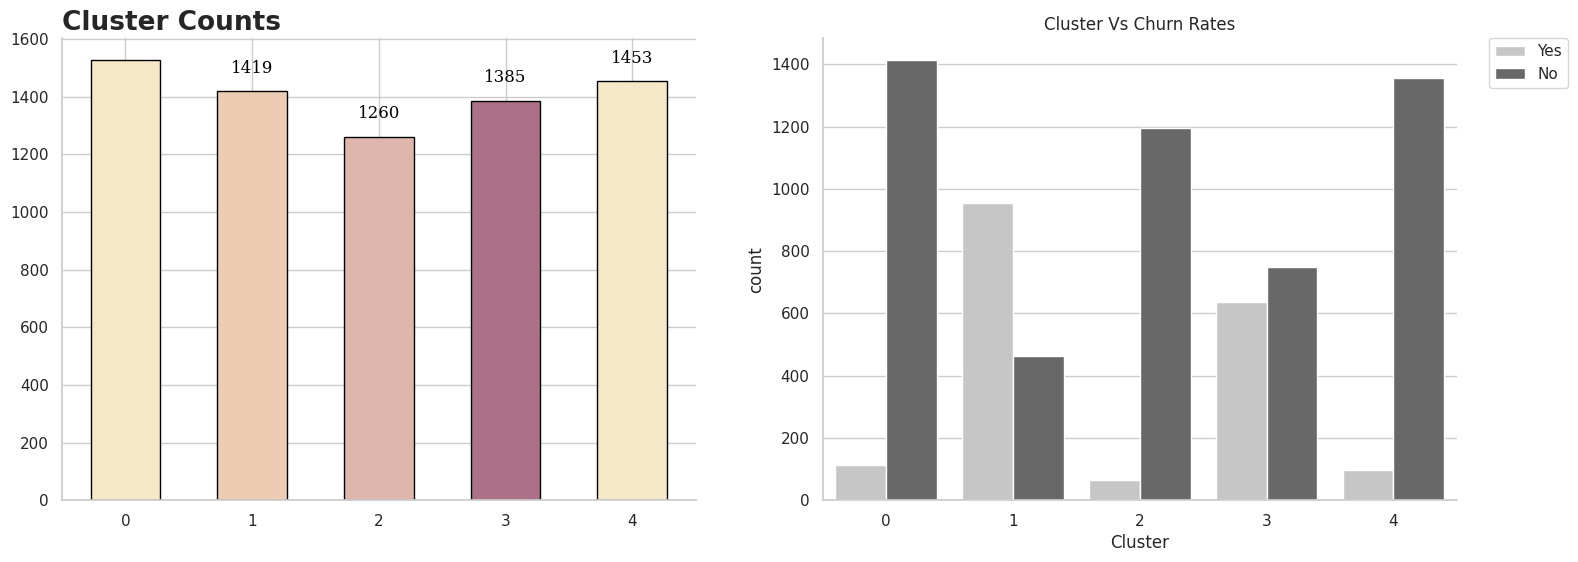

In [ ]:
# Plot cluster counts
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
data_temp = df['Cluster'].value_counts().sort_index()
colors = ['#F5E8C7', '#ECCCB2', '#DEB6AB', '#AC7088']
ax[0].bar(data_temp.index, data_temp, edgecolor='black', color=colors, width=0.55)
ax[0].set_title('Cluster Counts', loc='left', fontsize=19, fontweight='bold')

for i in data_temp.index:
    ax[0].annotate(f"{data_temp[i]}",
                   xy=(i, data_temp[i] + 80),
                   va='center', ha='center', fontweight='light', fontfamily='serif',
                   color='black')

for s in ['top', 'right']:
    ax[0].spines[s].set_visible(False)

# Plot cluster vs. churn rates
sns.countplot(x='Cluster', hue='Churn Label', palette='Greys', data=df)
sns.despine()
plt.legend( borderaxespad=0, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Cluster Vs Churn Rates')
plt.show()

- Tenure Months
- Device Class
- Games Product
- Music Product

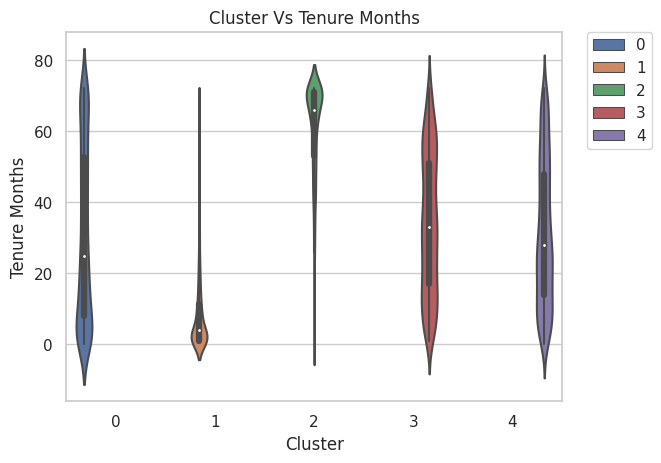

In [ ]:
# Plot cluster vs. Tenure Months
sns.set(style='whitegrid')
sns.violinplot(x='Cluster', y='Tenure Months', data=df, hue='Cluster')
plt.legend(title='',borderaxespad=0, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Cluster Vs Tenure Months')
plt.show()


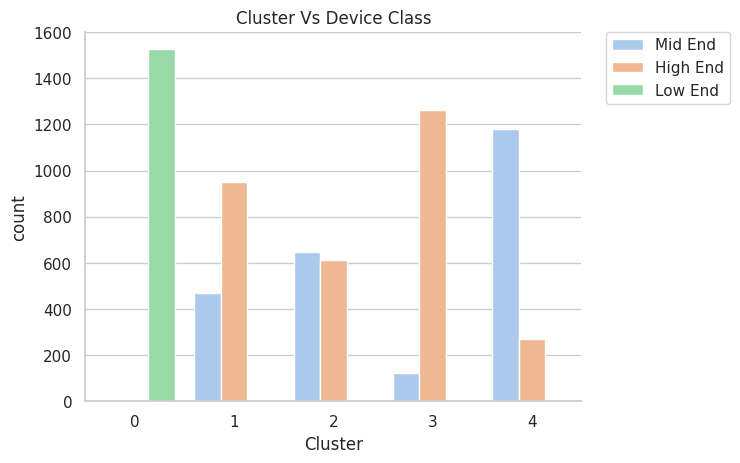

In [ ]:
# Plot cluster vs. Device Class
sns.countplot(x='Cluster', hue='Device Class', palette='pastel', data=df)
sns.despine()
plt.legend(borderaxespad=0, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Cluster Vs Device Class')
plt.show()

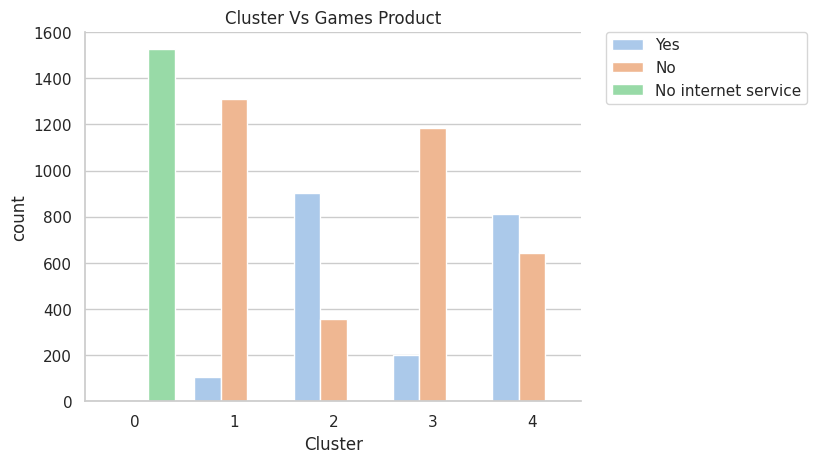

In [ ]:
# Plot cluster vs. Games Product
sns.countplot(x='Cluster', hue='Games Product', palette='pastel', data=df)
sns.despine()
plt.legend(title='', borderaxespad=0, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Cluster Vs Games Product')
plt.show()


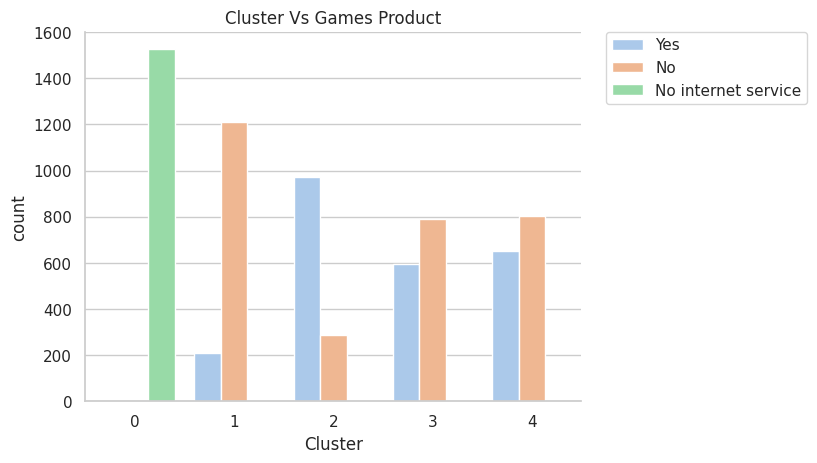

In [ ]:
# Plot cluster vs. Games Product
sns.countplot(x='Cluster', hue='Music Product', palette='pastel', data=df)
sns.despine()
plt.legend(title='', borderaxespad=0, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Cluster Vs Games Product')
plt.show()


- Payment Method
- Monthly_Purchase
- CLTV
- Total_Purchase

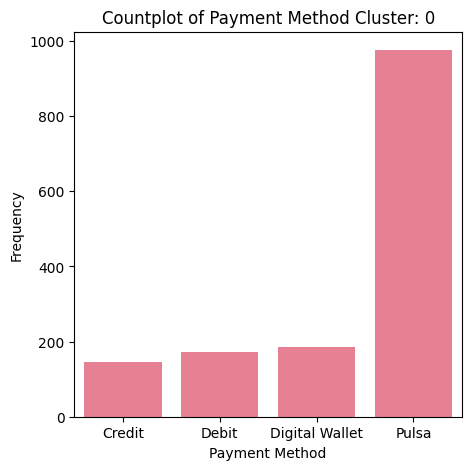

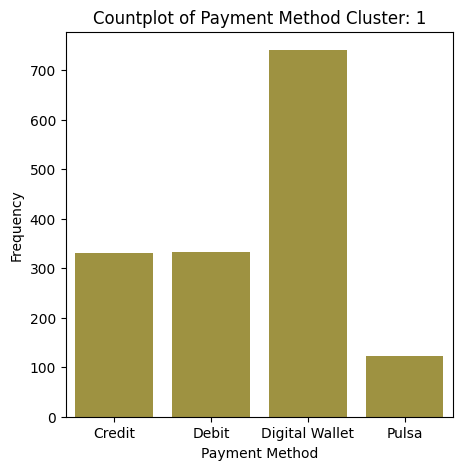

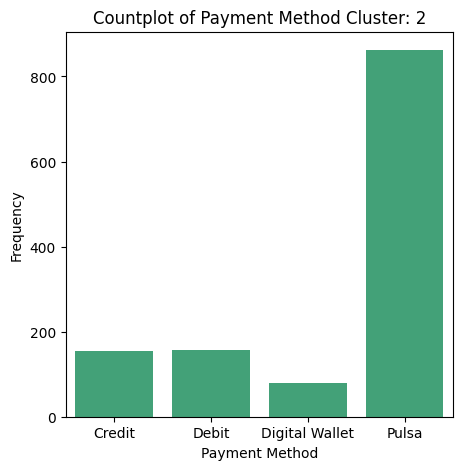

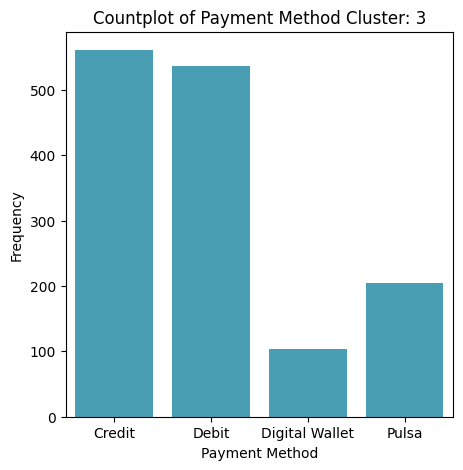

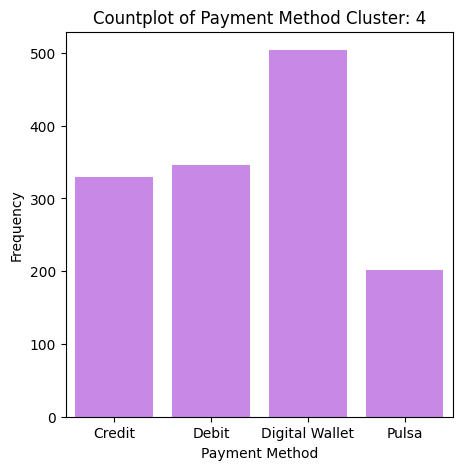

In [53]:
sorted_clusters = sorted(df["Cluster"].unique())

palette = sns.color_palette("husl", n_colors=len(sorted_clusters))

order = sorted(df['Payment Method'].unique())


for cluster in sorted_clusters:
  df_cluster = df[df["Cluster"] == cluster]

  plt.figure(figsize=(5, 5))

  sns.countplot(df_cluster, x="Payment Method", color=palette[cluster], order=order)

  # Adding labels and a title
  plt.xlabel('Payment Method')
  plt.ylabel('Frequency')
  plt.title(f'Countplot of Payment Method Cluster: {cluster}')

  # Showing the plot
  plt.show()

- Cluster 0 and 2 are similiar with most of the payment method is "Pulsa"
- Cluster 1 and 4 are similiar in distribution with high "Digital Wallet" proportion followed by equal "Credit" and "Debit" and low "Pulsa" proportion
- Cluster 3 is distinct with high "Credit" and "Debit" proportion and low "Digital Wallet" and "Pulsa"

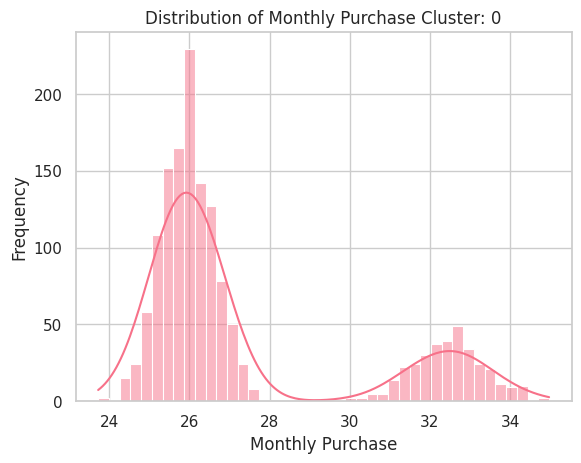

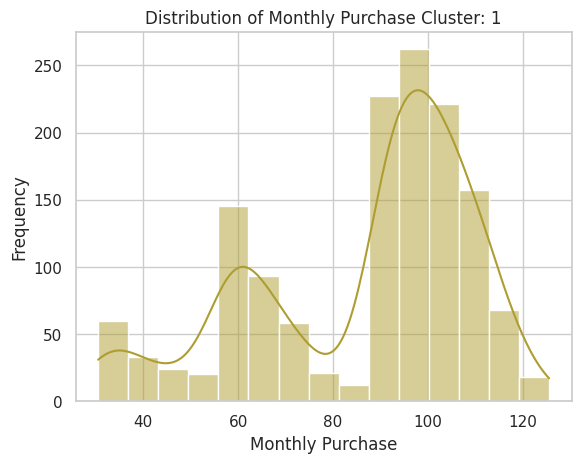

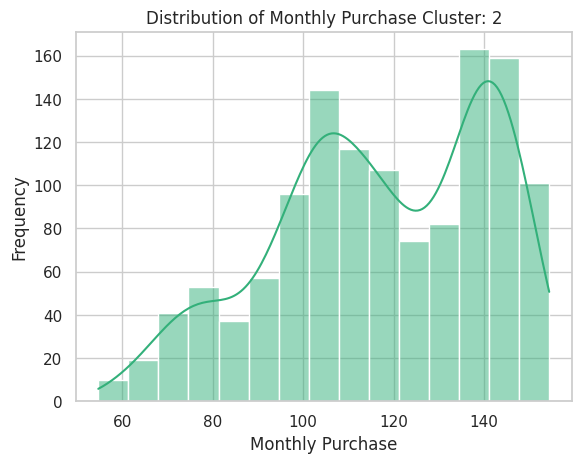

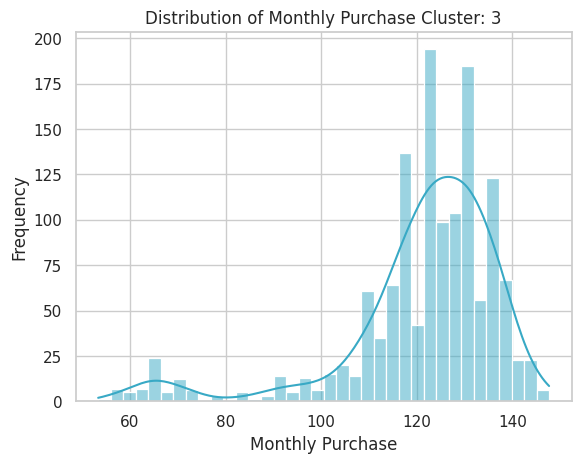

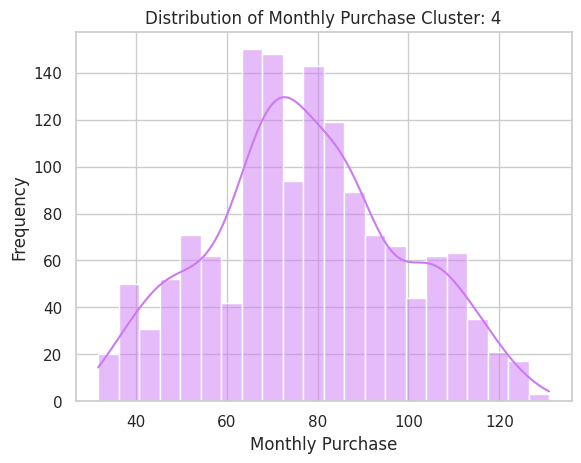

In [ ]:
sorted_clusters = sorted(df["Cluster"].unique())

palette = sns.color_palette("husl", n_colors=len(sorted_clusters))

for cluster in sorted_clusters:

  df_cluster = df[df["Cluster"] == cluster]

  sns.histplot(data=df_cluster, x="Monthly_Purchase", kde=True, color=palette[cluster])


  # Adding labels and a title
  plt.xlabel('Monthly Purchase')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Monthly Purchase Cluster: {cluster}')

  # Showing the plot
  plt.show()

<Axes: xlabel='Monthly_Purchase', ylabel='Proportion'>

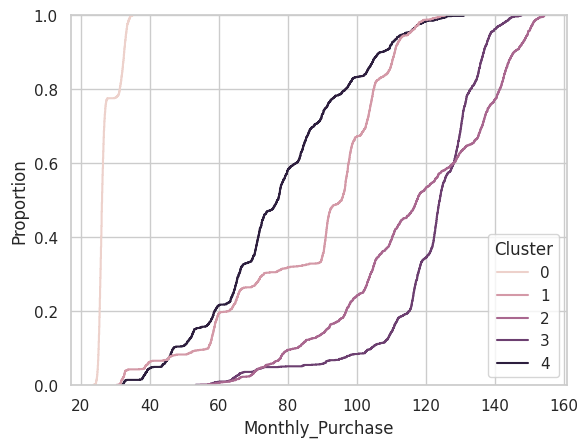

In [ ]:
sns.ecdfplot(data=df, x="Monthly_Purchase", hue="Cluster")

<Axes: xlabel='Monthly_Purchase', ylabel='Cluster'>

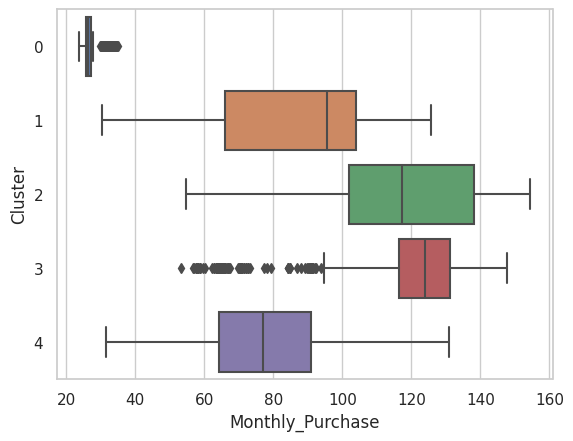

In [ ]:
df_violin = pd.DataFrame()

df_violin["Cluster"] = df["Cluster"].astype(str)
df_violin["Monthly_Purchase"] = df["Monthly_Purchase"]

order = sorted(df['Cluster'].unique())
order = list(map(lambda x: f"{x}", order))

sns.boxplot(data=df_violin, x="Monthly_Purchase", y="Cluster", order = order)

- Cluster 0 and 2 is similiar in the silhoutte of the distribution but has different ranges. Cluster 0 has lower range compared to Cluster 2. Cluster 0 and 2 also has a lot of negative outlier
- Cluster 1 has the most unique distirbution with a bimodal distirbution. Cluster 1 also has the lowest range compared to other cluster
- Cluster 3 has similiar range with Cluster 2. Cluster 3 also has a distinct ditribution compared to other cluster. The cluster looks to have a slight negative skew
- Cluster 4 has similiar range with Cluster 2 and its own distrinct distribution. It does not have any major skewness


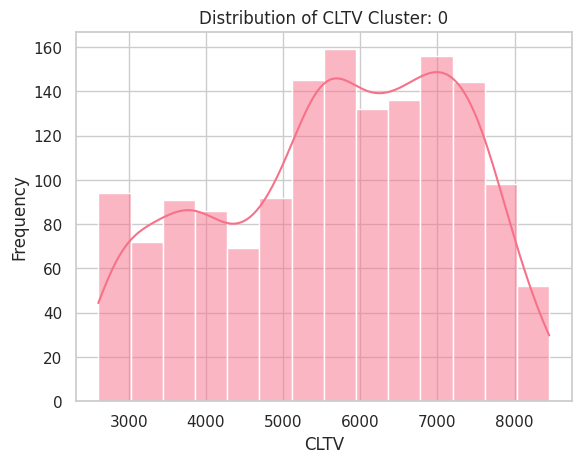

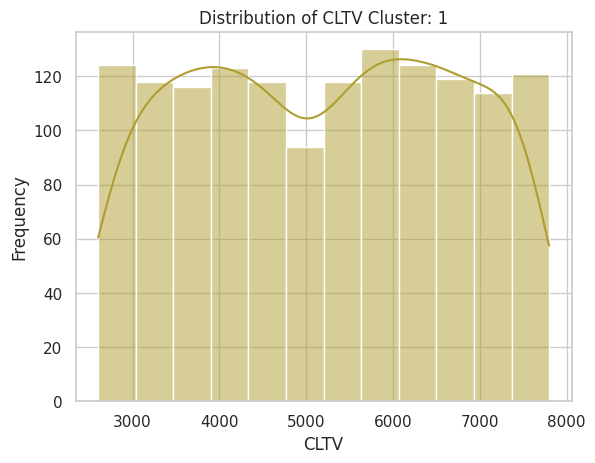

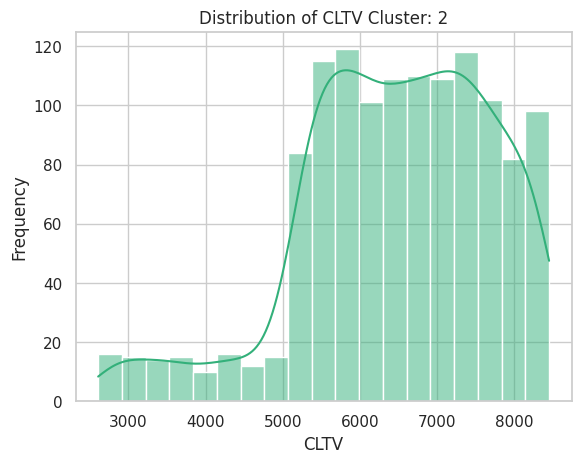

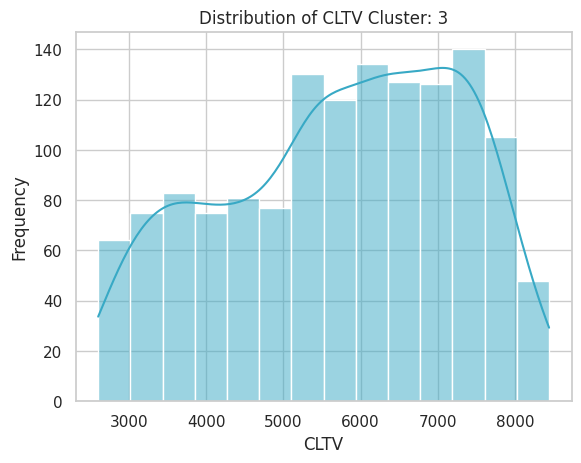

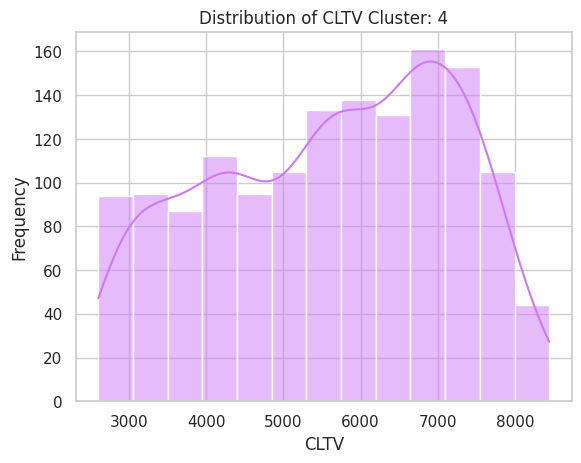

In [ ]:
sorted_clusters = sorted(df["Cluster"].unique())

palette = sns.color_palette("husl", n_colors=len(sorted_clusters))

for cluster in sorted_clusters:

  df_cluster = df[df["Cluster"] == cluster]


  sns.histplot(data=df_cluster, x="CLTV", kde=True, color=palette[cluster])

  # Adding labels and a title
  plt.xlabel('CLTV')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of CLTV Cluster: {cluster}')

  # Showing the plot
  plt.show()

<Axes: xlabel='CLTV', ylabel='Proportion'>

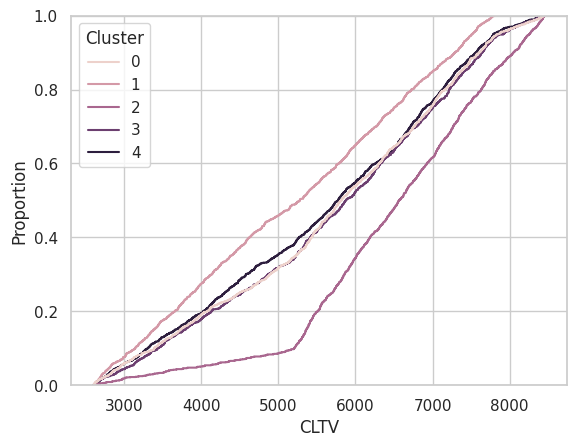

In [ ]:
sns.ecdfplot(data=df, x="CLTV", hue="Cluster")

<Axes: xlabel='CLTV', ylabel='Cluster'>

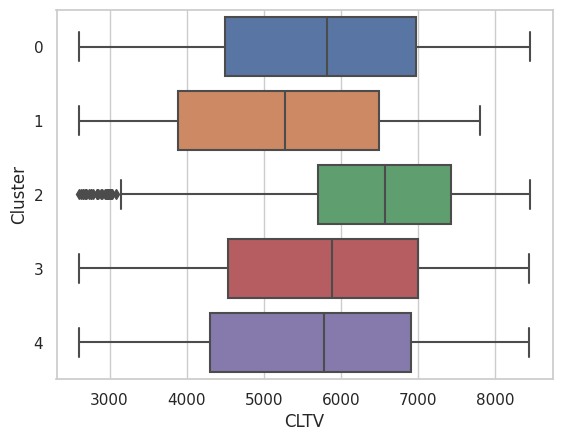

In [ ]:
df_violin = pd.DataFrame()

df_violin["Cluster"] = df["Cluster"].astype(str)
df_violin["CLTV"] = df["CLTV"]

order = sorted(df['Cluster'].unique())
order = list(map(lambda x: f"{x}", order))

sns.boxplot(data=df_violin, x="CLTV", y="Cluster", order = order)

- Cluster 0 has a wider peak that looks like a uniform distribution
- Cluster 1, 2, and 4 has similiar distirbution.
- Cluster 3 has a distinct distribution. The distribution has a low proportion of value between 3000 - 5000
- The range of all distirbution is similiar


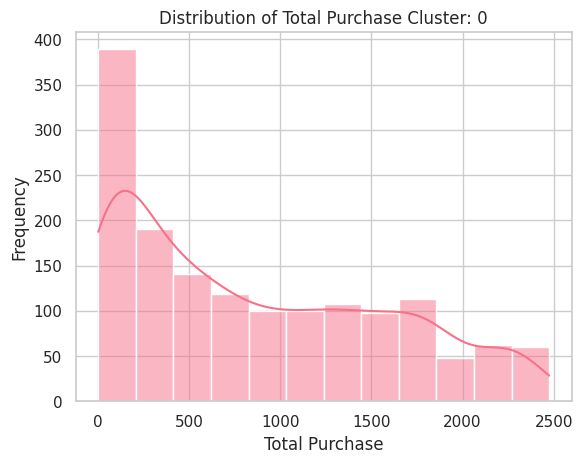

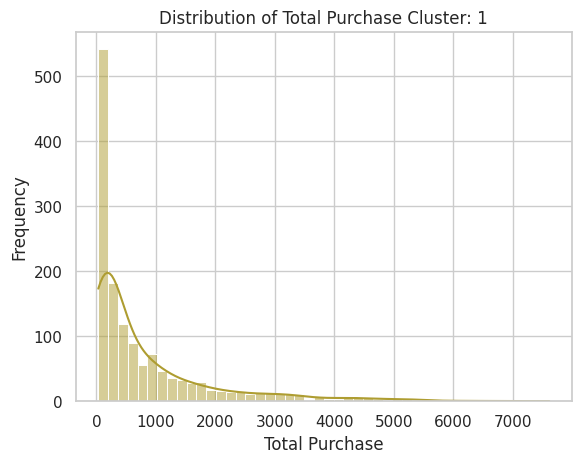

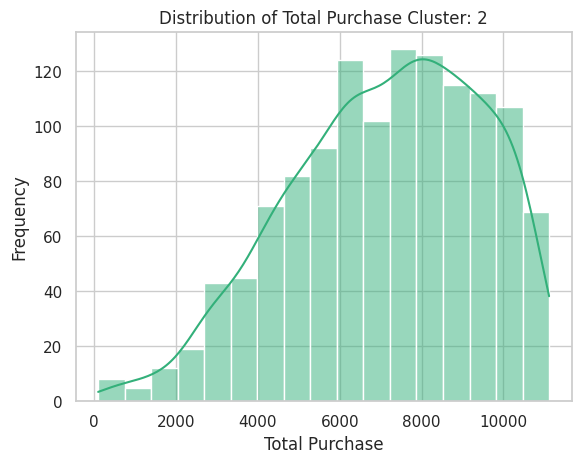

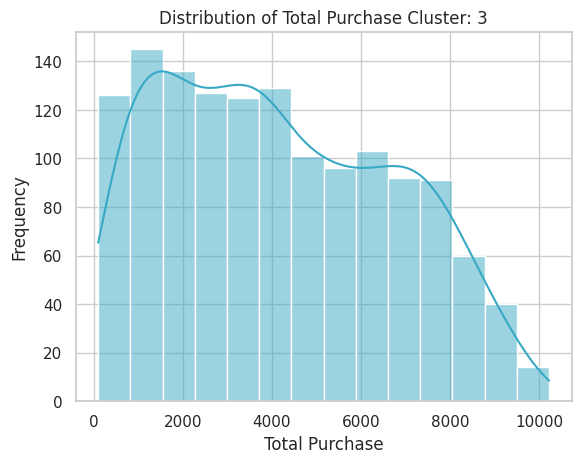

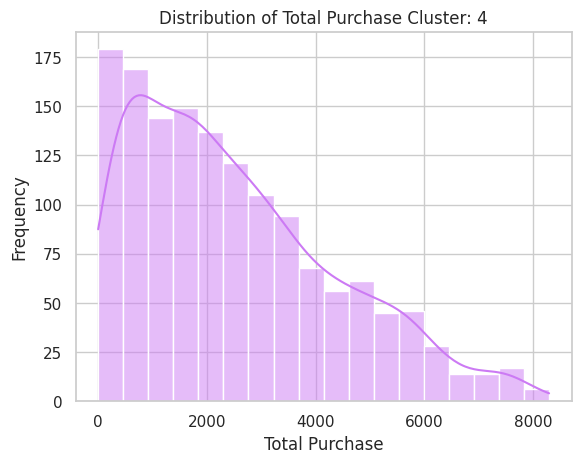

In [ ]:
sorted_clusters = sorted(df["Cluster"].unique())

palette = sns.color_palette("husl", n_colors=len(sorted_clusters))

for cluster in sorted_clusters:

  df_cluster = df[df["Cluster"] == cluster]


  sns.histplot(data=df_cluster, x="Total_Purchase", kde=True, color=palette[cluster])

  # Adding labels and a title
  plt.xlabel('Total Purchase')
  plt.ylabel('Frequency')
  plt.title(f'Distribution of Total Purchase Cluster: {cluster}')

  # Showing the plot
  plt.show()

<Axes: xlabel='Total_Purchase', ylabel='Proportion'>

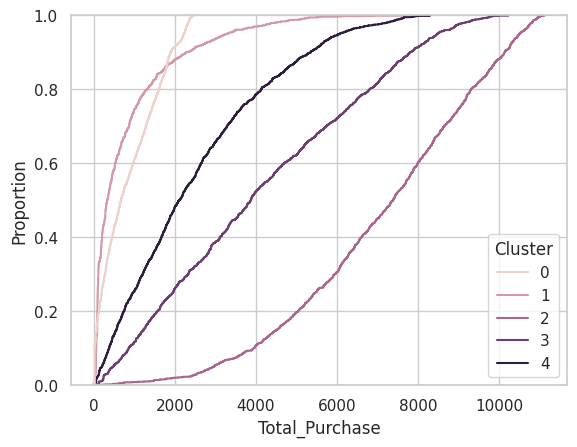

In [ ]:
sns.ecdfplot(data=df, x="Total_Purchase", hue="Cluster")

<Axes: xlabel='Total_Purchase', ylabel='Cluster'>

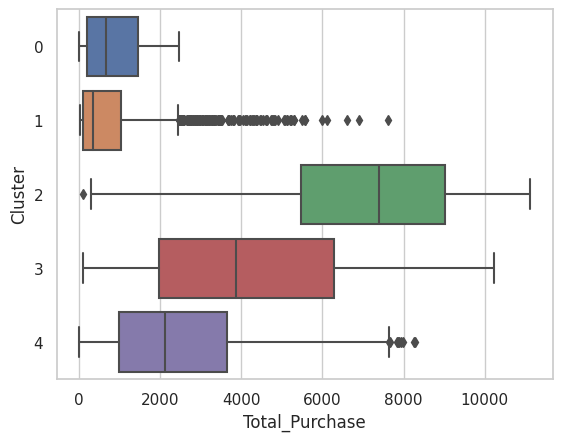

In [ ]:
df_violin = pd.DataFrame()

df_violin["Cluster"] = df["Cluster"].astype(str)
df_violin["Total_Purchase"] = df["Total_Purchase"]

order = sorted(df['Cluster'].unique())
order = list(map(lambda x: f"{x}", order))

sns.boxplot(data=df_violin, x="Total_Purchase", y="Cluster", order = order)

- Cluster 0, 1, and 4 has similiar distribution. However, the reange for each distribution is different. Cluster 0 has the most positive outliers. Cluster 1 shows no outliers and the shortest range. Cluster 4 has the widest range in general and many outliers. The cluster looks to have a fat positive tail
- Cluster 2 distirbution looks similiar to the other cluster but the tail is thicker. Cluster 2 has positive skewness
- Cluster 3 has the most distinct distirbution and the widest range compared to other clusters. Compared to other cluster, Cluster 3 has a slight negative skewness.